In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

/home/aj2309/.local/share/virtualenvs/Speech-Command-Classification-using-RRNN-6uPQ0_80/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
keras = tf.keras
Input = keras.layers.Input
Conv2D = keras.layers.Conv2D
Flatten = keras.layers.Flatten
Dense = keras.layers.Dense
GlobalAveragePooling2D = keras.layers.GlobalAveragePooling2D
Concatenate = keras.layers.Concatenate
Model = keras.Model

In [3]:
train_data = np.load('./data/train_data.npy')
train_labels = np.load('./data/train_labels.npy')

validation_data = np.load('./data/validation_data.npy')
validation_labels = np.load('./data/validation_labels.npy')

test_data = np.load('./data/test_data.npy')
test_labels = np.load('./data/test_labels.npy')

In [4]:
# One-hot encode the labels
PATH_TO_DATA = os.path.join(os.getcwd(), 'data')
PATH_TO_AUDIO = os.path.join(PATH_TO_DATA, 'audio')
LABELS = os.listdir(PATH_TO_AUDIO)
NUM_CLASSES = len(LABELS)
label_encoder = LabelEncoder().fit(LABELS)

train_labels = keras.utils.to_categorical(label_encoder.transform(train_labels), num_classes=NUM_CLASSES)
validation_labels = keras.utils.to_categorical(label_encoder.transform(validation_labels), num_classes=NUM_CLASSES)
test_labels = keras.utils.to_categorical(label_encoder.transform(test_labels), num_classes=NUM_CLASSES)

In [5]:
# Reshape data for compatibility with Keras
train_data = train_data.reshape((*train_data.shape, 1))
validation_data = validation_data.reshape((*validation_data.shape, 1))
test_data = test_data.reshape((*test_data.shape, 1))

#### Basic CNN Model

In [ ]:
# keras.backend.clear_session()

In [41]:
input_layer = Input(shape=train_data.shape[1:])
conv_1 = Conv2D(filters=48, kernel_size=(8, 3), padding='same', activation='relu')(input_layer)
conv_2 = Conv2D(filters=48, kernel_size=(8, 3), padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters=36, kernel_size=(8, 3), padding='same', activation='relu')(conv_2)
concat = Concatenate(axis=3)([conv_3, conv_1])
conv_4 = Conv2D(filters=48, kernel_size=(8, 3), padding='same', activation='relu')(concat)
conv_5 = Conv2D(filters=36, kernel_size=(8, 3), padding='same', activation='relu')(conv_4)
gap_1 = GlobalAveragePooling2D()(conv_5)
dense = Dense(30, activation='softmax')(gap_1)
model = Model(inputs=input_layer, outputs=dense)

# Display model summary for reference
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 63, 1)   0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 63, 48)  1200        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 63, 48)  55344       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 63, 36)  41508       conv2d_11[0][0]                  
__________________________________________________________________________________________________
concatenat

Define callbacks

In [7]:
ARCH_NAME = 'arch3_100e_512b'

In [46]:
early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, 
                                                    patience=10, 
                                                    verbose=0, 
                                                    mode='auto')

reduce_lr_plateau_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                               factor=0.1, 
                                                               patience=5, 
                                                               verbose=0, 
                                                               mode='auto', 
                                                               cooldown=0, min_lr=0)
csv_logger = keras.callbacks.CSVLogger(ARCH_NAME + '.csv')

callbacks = [early_stop_callback, reduce_lr_plateau_callback, csv_logger]

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, 
          train_labels, 
          epochs=100, 
          batch_size=512, 
          validation_data=(validation_data, validation_labels), 
          shuffle=True,
          callbacks=callbacks,
          verbose=1)

Train on 51088 samples, validate on 6798 samples
Epoch 1/100
51088/51088 [==============================] - 129s 3ms/step - loss: 3.3514 - acc: 0.0561 - val_loss: 3.2308 - val_acc: 0.0828
Epoch 2/100
51088/51088 [==============================] - 122s 2ms/step - loss: 2.9988 - acc: 0.1443 - val_loss: 2.7672 - val_acc: 0.2021
Epoch 3/100
51088/51088 [==============================] - 122s 2ms/step - loss: 2.5449 - acc: 0.2661 - val_loss: 2.2543 - val_acc: 0.3438
Epoch 4/100
51088/51088 [==============================] - 122s 2ms/step - loss: 2.1300 - acc: 0.3776 - val_loss: 1.9260 - val_acc: 0.4329
Epoch 5/100
51088/51088 [==============================] - 122s 2ms/step - loss: 1.8148 - acc: 0.4714 - val_loss: 1.6681 - val_acc: 0.5128
Epoch 6/100
51088/51088 [==============================] - 122s 2ms/step - loss: 1.5472 - acc: 0.5541 - val_loss: 1.4802 - val_acc: 0.5696
Epoch 7/100
51088/51088 [==============================] - 122s 2ms/step - loss: 1.3722 - acc: 0.6067 - val_loss: 1.2

In [ ]:
model.save(ARCH_NAME + '.h5')

In [8]:
model = keras.models.load_model(ARCH_NAME + '.h5')

In [9]:
test_pred_encoded = model.predict(test_data)

In [12]:
test_pred = test_pred_encoded.argmax(axis=-1)

In [13]:
test_labels_ = test_labels.argmax(axis=-1)

In [14]:
test_loss, test_acc = model.evaluate(test_data, test_labels)

6835/6835 [==============================] - 7s 999us/step


In [15]:
test_acc

0.8769568397515694

In [16]:
test_loss

0.5219248884009373

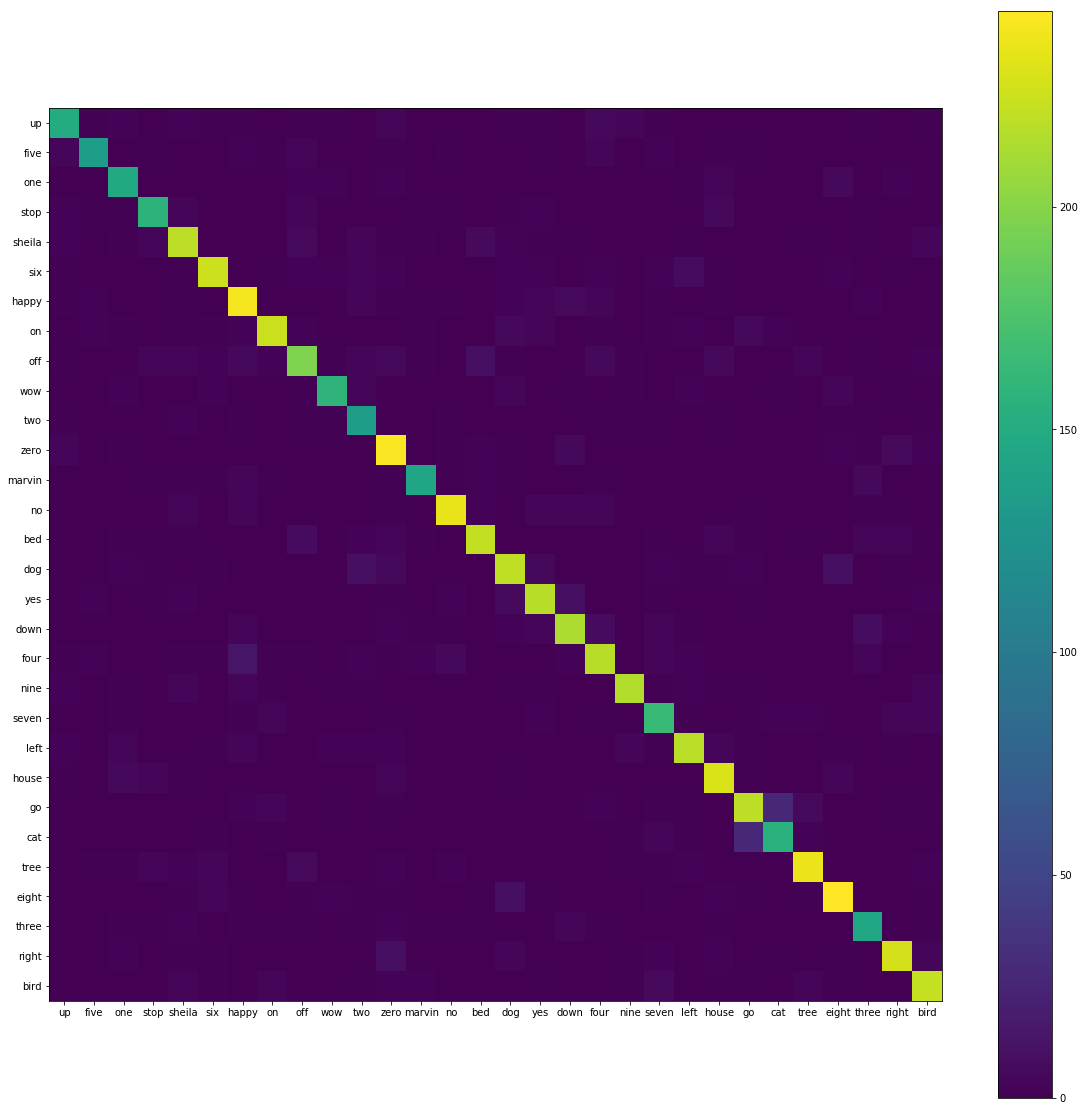

In [17]:
plt.figure(figsize=(20, 20))
plt.imshow(confusion_matrix(test_labels_, test_pred))
plt.xticks(range(30), LABELS)
plt.yticks(range(30), LABELS)
plt.colorbar()
plt.show()